In [20]:
import tqdm
import os
import glob
import datetime


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import process_times

In [21]:
FIGURES_PATH = os.path.join("..", "figures")
TEAM_COLORS = {
    "Mercedes":"#00D2BE",
    "Custom":(22.6/255.0, 21.1/255.0, 29.0/255.0),
    "Mc Laren":"#FF8700",
    "Ferrari":"#DC0000",
    "Red Bull":"#0600EF",
    "Alpine":"#0090FF",
    "Aston Martin":"#006F62",
    "Haas":"#8c8c8c",
    "Williams":"#005AFF",
    "Alfa Romeo":"#900000",
    "AlphaTauri":"#2B4562",
}

assists = ["tc", "brakes", "gear"]
assist_2_str = {
    "tc": "Traction Control",
    "brakes": "ABS",
    "gear": "Automatic Gearbox"
}

In [22]:
def read_all(dir):
    csvs = glob.glob(os.path.join(dir, "*.csv"))
    dfs = {}
    for csv in csvs:
        circuit_name = os.path.basename(csv).split(".")[0]
        dfs[circuit_name] = process_times.read_and_filter_csv(csv)

    return dfs


In [23]:
dfs = read_all(os.path.join("..", "data"))

In [24]:
def pie_assists(dfs, tops, figures_path=None):
    for top in tops:
        usage = {
            "Traction Control":0,"ABS":0,"Automatic Gearbox":0
        }
        count = 0
        for circuit in dfs.keys():
            counts = dfs[circuit].iloc[:top,:][assists].sum().to_dict()
            usage["Traction Control"] += counts["tc"]
            usage["ABS"] += counts["brakes"]
            usage["Automatic Gearbox"] += counts["gear"]
            count += dfs[circuit].shape[0]

        fig, ax = plt.subplots(ncols=3, figsize=(5*3, 5))
        if top != -1:
            fig.suptitle(f"Assist usage top {top} laps", fontsize=16)
        else:
            fig.suptitle(f"Assist usage all times", fontsize=16)
            
        fig.set_facecolor("w")
        for i, assist in enumerate(usage.keys()):
            weights = [usage[assist]/count, 1.0 - usage[assist]/count]
            ax[i].pie(weights, labels=["Yes", "No"], autopct='%1.1f%%')
            ax[i].set_title(assist)

        if figures_path != None:
            plt.savefig(os.path.join(figures_path, f"pie_assist_top_{top}.png"), dpi=100, bbox_inches="tight")
            
        plt.show()
        

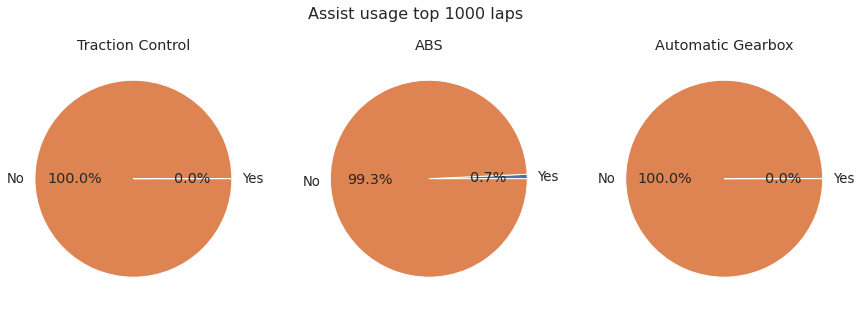

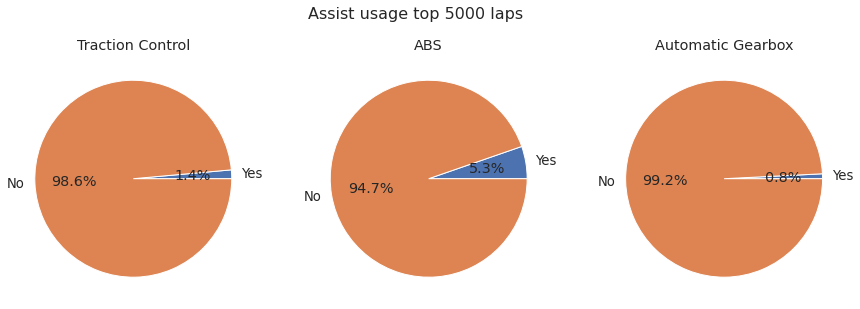

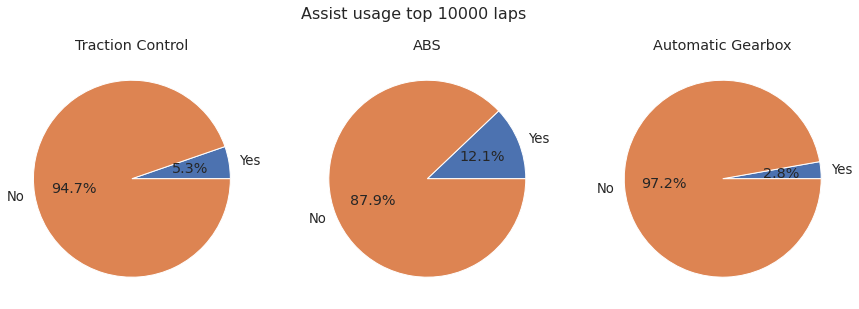

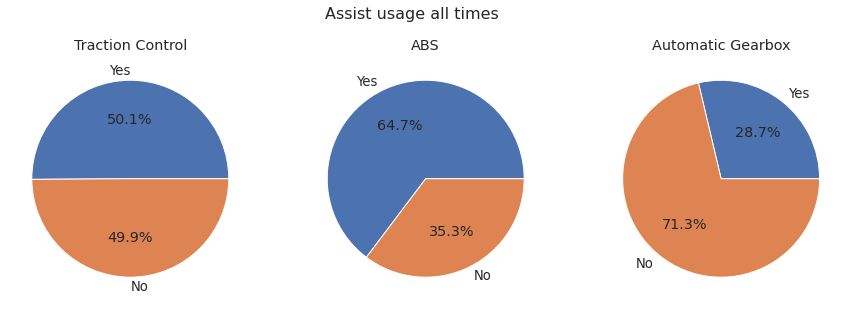

In [25]:
pie_assists(dfs, [1000, 5000, 10000, -1], FIGURES_PATH)

In [26]:
def box_assists(dfs, step_size, figures_path=None):
    steps = range(step_size, 50000 + step_size, step_size)
    

    for i, assist in enumerate(assists):
        percentages = []
        labels = []
        for top in steps:
            values = []
            for circuit in dfs.keys():
                values.append(dfs[circuit].iloc[:top,:][assist].sum() / dfs[circuit].shape[0])

            labels.append(top)
            percentages.append(values)

        fig, ax = plt.subplots(figsize=(15, 7))
        ax.boxplot(percentages)
        ax.set_xticklabels(labels)
        ax.set_title(assist_2_str[assist])
        ax.set_ylim([0,1])
        plt.show()

        if figures_path != None:
            plt.savefig(os.path.join(figures_path, f"box_{assist}.png"), dpi=100, bbox_inches="tight")

    return plt.show()

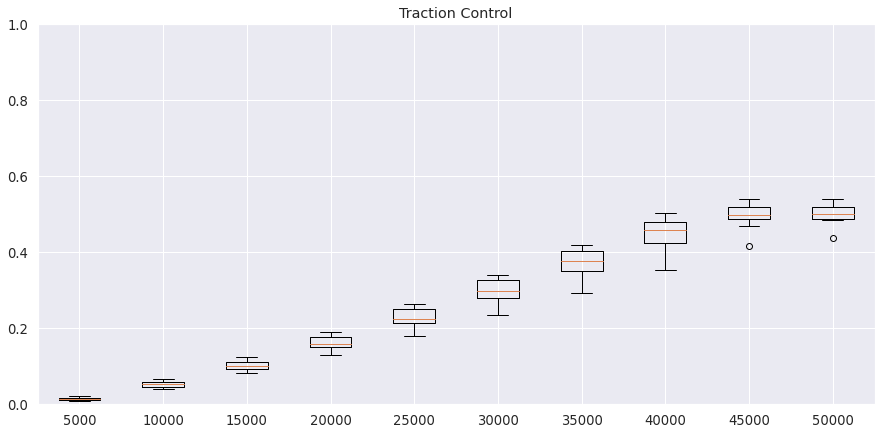

<Figure size 842.4x595.44 with 0 Axes>

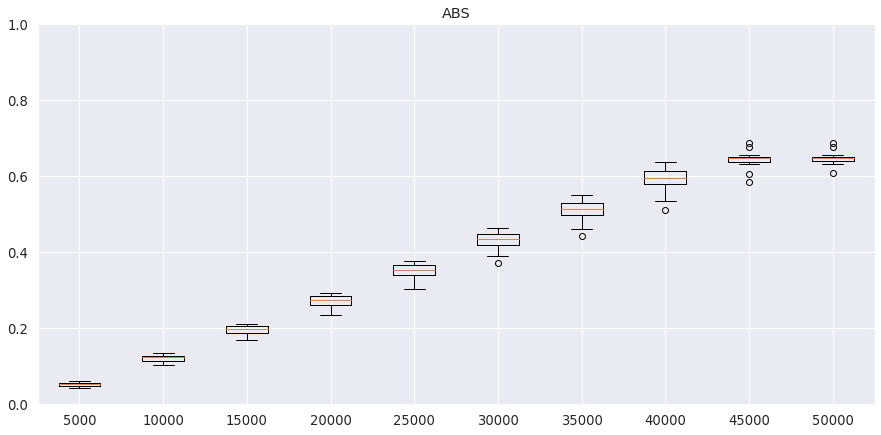

<Figure size 842.4x595.44 with 0 Axes>

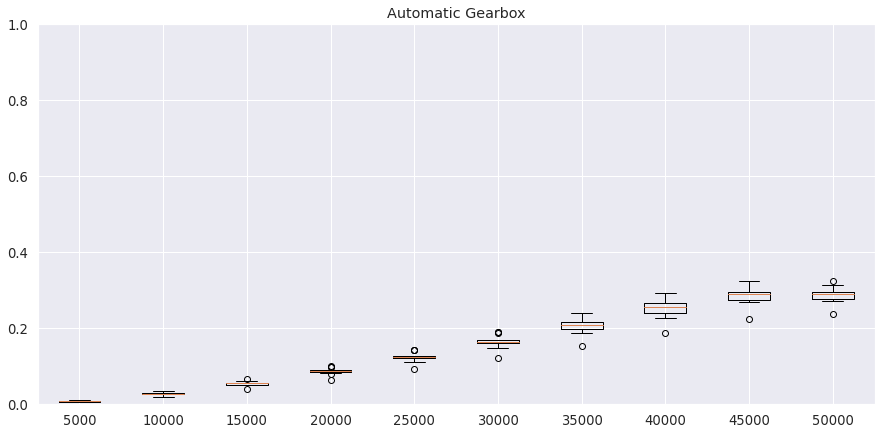

<Figure size 842.4x595.44 with 0 Axes>

In [27]:
box_assists(dfs, 5000, FIGURES_PATH)

In [28]:
def plot_assists_circuit(dfs, top=None, figures_path=None):
    rcParams['figure.figsize'] = 11.7,8.27
    sns.set_theme(style="darkgrid")
    sns.set(font_scale=1.2)

    for assist in assists:
        vals = []
        for circuit in dfs.keys():
            if top != None:
                vals.append((dfs[circuit].iloc[:top,:][assist].sum() * 100.0 / dfs[circuit].iloc[:top,:].shape[0], circuit))
            else:
                vals.append((dfs[circuit][assist].sum() * 100.0 / dfs[circuit].shape[0], circuit))
        
        df = pd.DataFrame(vals, columns=["Assist On (%)", "Circuit"]).sort_values(["Assist On (%)", "Circuit"], ascending=False)
        
        ax = sns.barplot(x="Circuit", y="Assist On (%)", data=df)
        if top != None:
            ax.set_title(f"{assist_2_str[assist]} (Top {top} laps)")
        else:
            ax.set_title(f"{assist_2_str[assist]} (All laps)")
        ax.set_ylim([0,100])
        ax.bar_label(ax.containers[0], fmt="%.1f")
        plt.xticks(rotation=45)

        if figures_path != None:
            plt.savefig(os.path.join(figures_path, f"assist_circuit_{assist}_top_{top}.png"), dpi=100, bbox_inches="tight")

        plt.show()

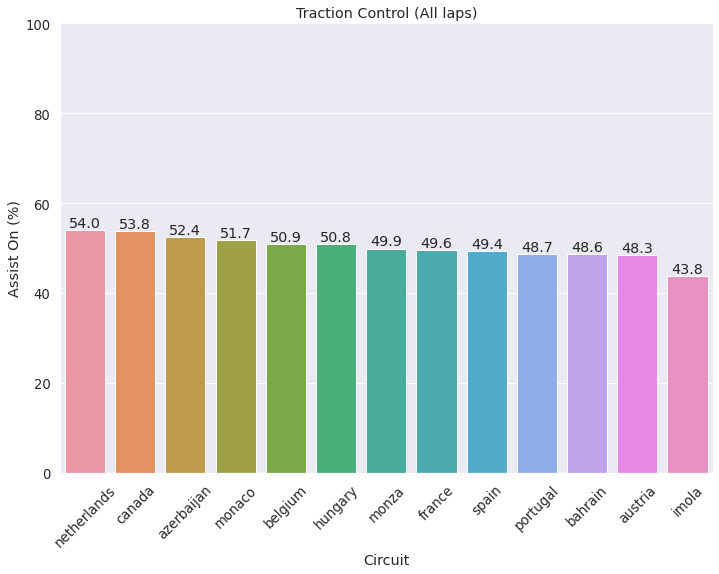

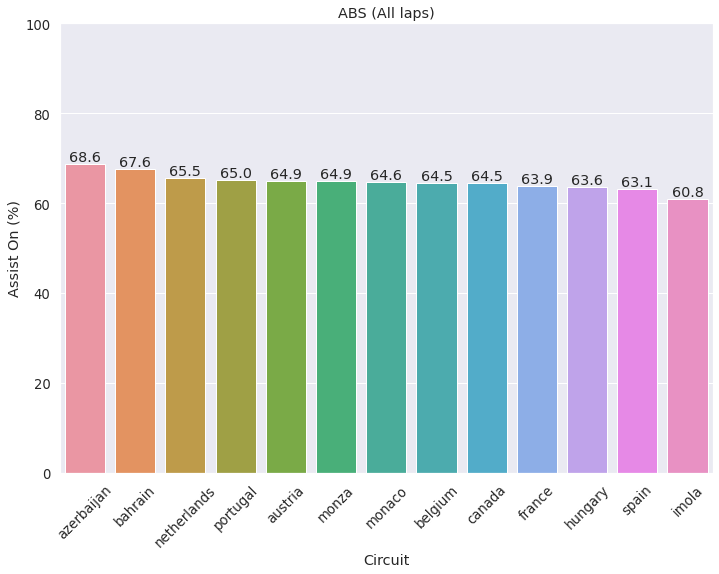

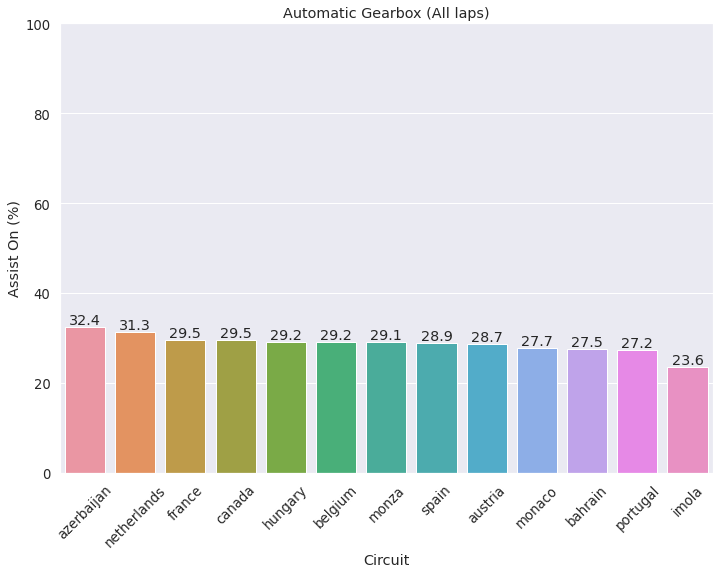

In [29]:
plot_assists_circuit(dfs, None, FIGURES_PATH)

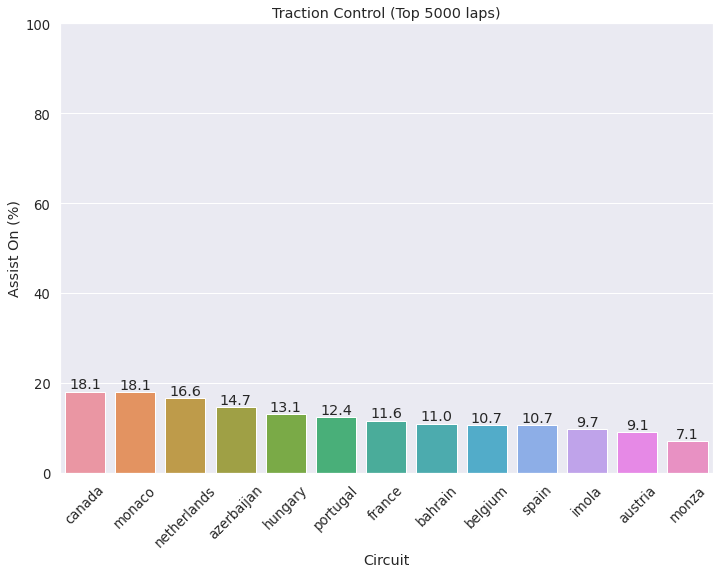

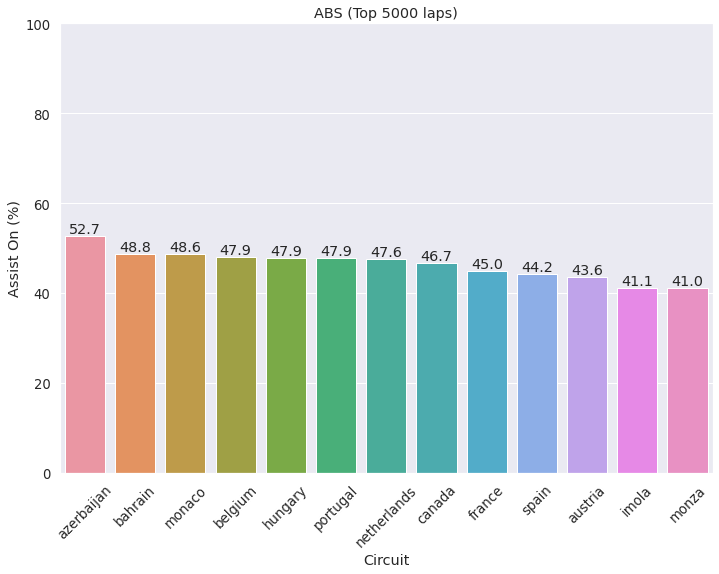

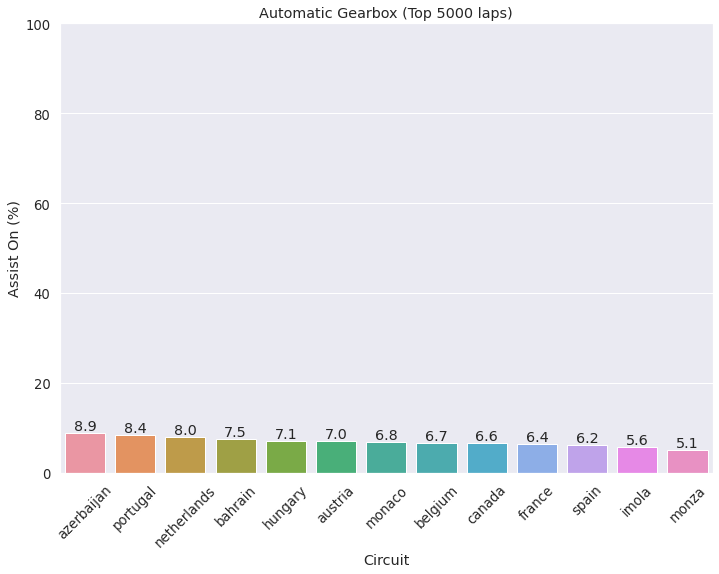

In [30]:
plot_assists_circuit(dfs,5000,FIGURES_PATH)

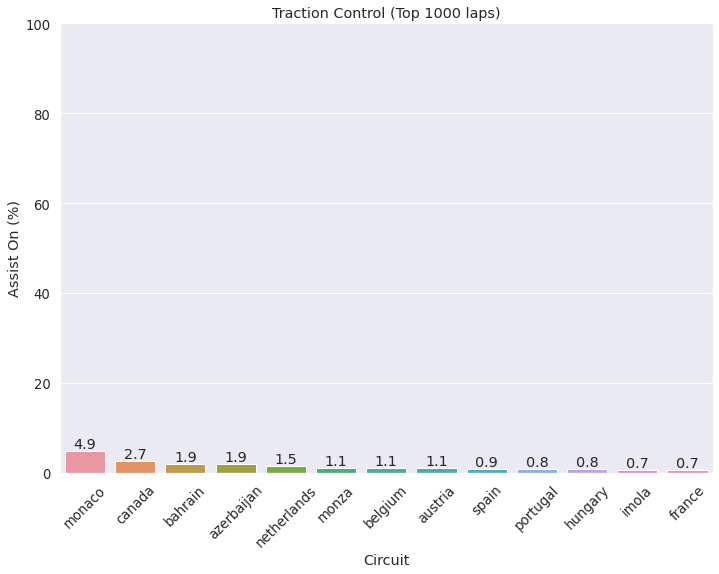

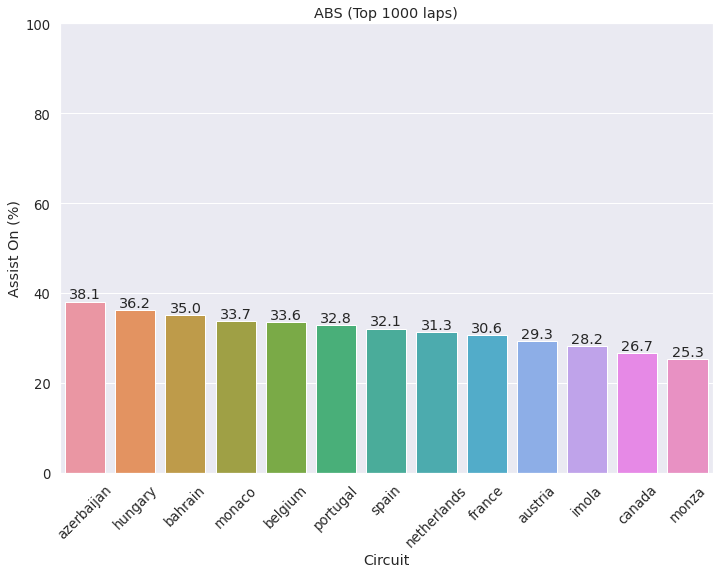

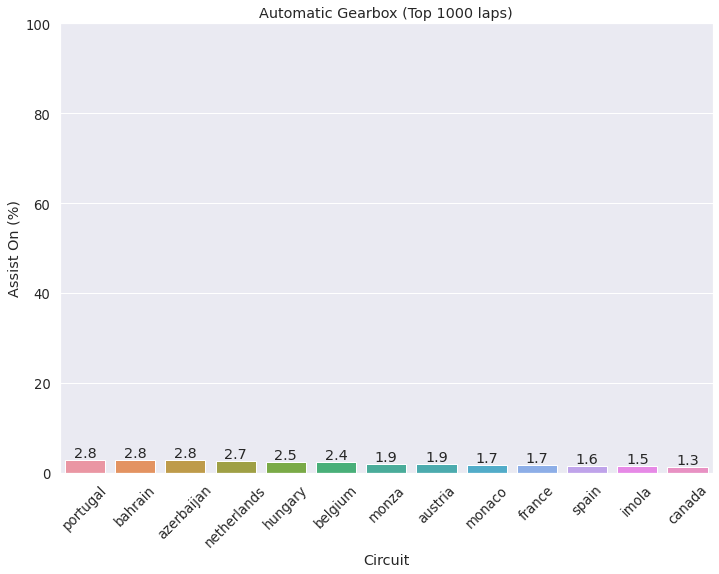

In [31]:
plot_assists_circuit(dfs,1000,FIGURES_PATH)

In [32]:
def plot_team_circuit_delta(dfs, figures_path=None):
    df = pd.DataFrame()
    for circuit in dfs.keys():
        avg_times = dfs[circuit].groupby("team").mean().sort_values("time_s")
        avg_times[circuit] = (avg_times["time_s"] - avg_times["time_s"].iloc[0])
        df = pd.concat([df, avg_times[circuit]],axis=1)


    ax = sns.lineplot(data=df.T, dashes=False, markers=False, linewidth=1.5, palette=TEAM_COLORS)
    ax.set(xlabel="Circuit", ylabel="Time delta (s)")
    ax.set_title(f"Average time delta from the best lap")

    team_labels = df.T.columns.values
    for i, team in enumerate(team_labels):
        team_labels[i] += f" ({df.T[team].mean():.3f}s)"

    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=team_labels)


    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        
    plt.xticks(rotation=45)
    
    if figures_path != None:
        plt.savefig(os.path.join(figures_path, f"team_delta_circuit.png"), dpi=100, bbox_inches="tight")

    return plt.show()

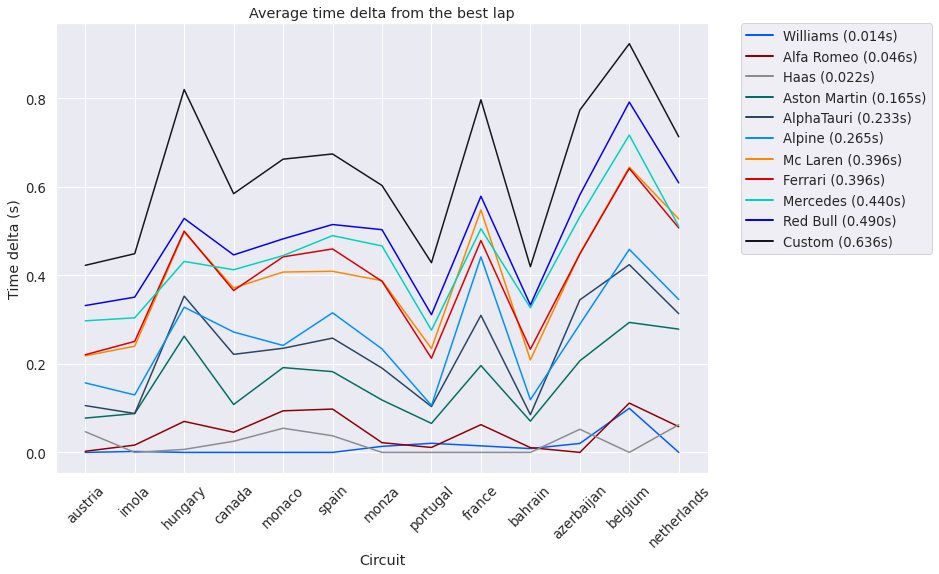

In [33]:
plot_team_circuit_delta(dfs, FIGURES_PATH)